In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:

# Load the training and test datasets
train = pd.read_csv('C:/Users/MANOJ/Desktop/modified_dataset.csv')
test = pd.read_csv('test_dataset.csv')
train.info()
train.nunique()
train['slice Type'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31583 entries, 0 to 31582
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LTE/5g Category       31583 non-null  int64  
 1   Time                  31583 non-null  int64  
 2   Packet Loss Rate      31583 non-null  float64
 3   Packet delay          31583 non-null  int64  
 4   IoT                   31583 non-null  int64  
 5   LTE/5G                31583 non-null  int64  
 6   GBR                   31583 non-null  int64  
 7   Non-GBR               31583 non-null  int64  
 8   AR/VR/Gaming          31583 non-null  int64  
 9   Healthcare            31583 non-null  int64  
 10  Industry 4.0          31583 non-null  int64  
 11  IoT Devices           31583 non-null  int64  
 12  Public Safety         31583 non-null  int64  
 13  Smart City & Home     31583 non-null  int64  
 14  Smart Transportation  31583 non-null  int64  
 15  Smartphone         

1    16490
2     7698
3     7395
Name: slice Type, dtype: int64

In [3]:
# Perform data preprocessing and optimization
def reduce_mem_usage(train):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = train.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in train.columns:
        col_type = train[col].dtype
        
        if col_type != object:
            c_min = train[col].min()
            c_max = train[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train[col] = train[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train[col] = train[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train[col] = train[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train[col] = train[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train[col] = train[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train[col] = train[col].astype(np.float32)
                else:
                    train[col] = train[col].astype(np.float64)
        else:
            train[col] = train[col].astype('object')

    end_mem = train.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return train

In [4]:
# Reduce memory usage of the train dataset
train = reduce_mem_usage(train)
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31583 entries, 0 to 31582
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LTE/5g Category       31583 non-null  int8   
 1   Time                  31583 non-null  int8   
 2   Packet Loss Rate      31583 non-null  float16
 3   Packet delay          31583 non-null  int16  
 4   IoT                   31583 non-null  int8   
 5   LTE/5G                31583 non-null  int8   
 6   GBR                   31583 non-null  int8   
 7   Non-GBR               31583 non-null  int8   
 8   AR/VR/Gaming          31583 non-null  int8   
 9   Healthcare            31583 non-null  int8   
 10  Industry 4.0          31583 non-null  int8   
 11  IoT Devices           31583 non-null  int8   
 12  Public Safety         31583 non-null  int8   
 13  Smart City & Home     31583 non-null  int8   
 14  Smart Transportation  31583 non-null  int8   
 15  Smartphone         

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31584 entries, 0 to 31583
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LTE/5g Category       31584 non-null  int64  
 1   Time                  31584 non-null  int64  
 2   Packet Loss Rate      31584 non-null  float64
 3   Packet delay          31584 non-null  int64  
 4   IoT                   31584 non-null  int64  
 5   LTE/5G                31584 non-null  int64  
 6   GBR                   31584 non-null  int64  
 7   Non-GBR               31584 non-null  int64  
 8   AR/VR/Gaming          31584 non-null  int64  
 9   Healthcare            31584 non-null  int64  
 10  Industry 4.0          31584 non-null  int64  
 11  IoT Devices           31584 non-null  int64  
 12  Public Safety         31584 non-null  int64  
 13  Smart City & Home     31584 non-null  int64  
 14  Smart Transportation  31584 non-null  int64  
 15  Smartphone         

In [6]:
# Reduce memory usage of the test dataset
test = reduce_mem_usage(test)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31584 entries, 0 to 31583
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LTE/5g Category       31584 non-null  int8   
 1   Time                  31584 non-null  int8   
 2   Packet Loss Rate      31584 non-null  float16
 3   Packet delay          31584 non-null  int16  
 4   IoT                   31584 non-null  int8   
 5   LTE/5G                31584 non-null  int8   
 6   GBR                   31584 non-null  int8   
 7   Non-GBR               31584 non-null  int8   
 8   AR/VR/Gaming          31584 non-null  int8   
 9   Healthcare            31584 non-null  int8   
 10  Industry 4.0          31584 non-null  int8   
 11  IoT Devices           31584 non-null  int8   
 12  Public Safety         31584 non-null  int8   
 13  Smart City & Home     31584 non-null  int8   
 14  Smart Transportation  31584 non-null  int8   
 15  Smartphone         

In [7]:
# Rename columns to remove special characters
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [8]:
train.head() #just listing all columns with first 5 rows.

,LTE5gCategory,Time,PacketLossRate,Packetdelay,IoT,LTE5G,GBR,NonGBR,ARVRGaming,Healthcare,Industry40,IoTDevices,PublicSafety,SmartCityHome,SmartTransportation,Smartphone,sliceType
0,14,0,0.000001,10,1,0,0,1,0,0,0,0,1,0,0,0,3
1,18,20,0.001000,100,0,1,1,0,1,0,0,0,0,0,0,0,1
2,17,14,0.000001,300,0,1,0,1,0,0,0,0,0,0,0,1,2
3,3,17,0.010002,100,0,1,0,1,0,0,0,0,0,0,0,1,1
4,9,4,0.010002,50,1,0,0,1,0,0,0,0,0,1,0,0,2


In [9]:
test.head() #just listing all columns with first 5 rows.


,LTE5gCategory,Time,PacketLossRate,Packetdelay,IoT,LTE5G,GBR,NonGBR,ARVRGaming,Healthcare,Industry40,IoTDevices,PublicSafety,SmartCityHome,SmartTransportation,Smartphone
0,15,17,0.001000,100,0,1,1,0,1,0,0,0,0,0,0,0
1,14,18,0.000001,10,1,0,0,1,0,0,0,0,0,0,1,0
2,11,7,0.001000,50,1,0,1,0,0,0,1,0,0,0,0,0
3,20,14,0.001000,50,1,0,1,0,0,0,1,0,0,0,0,0
4,2,22,0.001000,50,0,1,0,1,1,0,0,0,0,0,0,0


In [10]:
y = train.pop('sliceType')
X = train

# Convert non-numeric columns to numeric values
X = X.apply(pd.to_numeric, errors='coerce')

# Split the updated training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert labels to string type
y_train = y_train.astype(str)
y_val = y_val.astype(str)

In [11]:
X_train.shape[1]

16

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)


In [13]:
num_classes = len(label_encoder.classes_)
num_classes

3

In [14]:
y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes)

In [15]:
# Define the hybrid model without Embedding layer
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [16]:
# Adjust the learning rate
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
# Define a callback to save the best model
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 128)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 256)            98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 256)           0

In [19]:
history = model.fit(X_train, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=10,
                    validation_data=(X_val, y_val_categorical), 
                    callbacks=[checkpoint])

Epoch 1/10
789/790 [============================>.] - ETA: 0s - loss: 0.4156 - accuracy: 0.8334
Epoch 1: val_accuracy improved from -inf to 0.96945, saving model to model.h5
790/790 [==============================] - 22s 20ms/step - loss: 0.4153 - accuracy: 0.8335 - val_loss: 0.1772 - val_accuracy: 0.9694
Epoch 2/10
788/790 [============================>.] - ETA: 0s - loss: 0.1648 - accuracy: 0.9677
Epoch 2: val_accuracy did not improve from 0.96945
790/790 [==============================] - 14s 17ms/step - loss: 0.1648 - accuracy: 0.9677 - val_loss: 0.1422 - val_accuracy: 0.9694
Epoch 3/10
790/790 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9680
Epoch 3: val_accuracy did not improve from 0.96945
790/790 [==============================] - 14s 17ms/step - loss: 0.1566 - accuracy: 0.9680 - val_loss: 0.1390 - val_accuracy: 0.9694
Epoch 4/10
789/790 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9680
Epoch 4: val_accuracy did not improve

In [51]:
# Load the predictions file
predictions_df = pd.read_csv('C:/Users/MANOJ/Documents/FInal_Models/Capstone/predictions.csv')

# Extract the 'sliceType' column as y_test
y_test = predictions_df['sliceType']

X_test = test
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Convert labels to string type
y_test = y_test.astype(str)

# Encode labels
y_test_encoded = label_encoder.transform(y_test)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert predictions to class labels
test_pred_labels = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_encoded, test_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
from sklearn.metrics import classification_report
class_report = classification_report(y_test_encoded, test_pred_labels)

# Print classification report
print("\nClassification Report:")
print(class_report)


987/987 [==============================] - 6s 6ms/step
Confusion Matrix:
[[16800     0     0]
 [    0  7392     0]
 [    0     0  7392]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16800
           1       1.00      1.00      1.00      7392
           2       1.00      1.00      1.00      7392

    accuracy                           1.00     31584
   macro avg       1.00      1.00      1.00     31584
weighted avg       1.00      1.00      1.00     31584



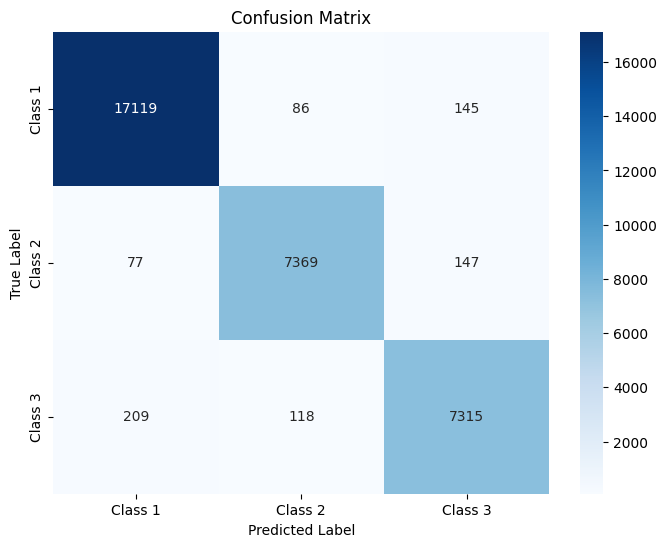

In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix
conf_matrix = np.array([[17119, 86, 145],
                        [77, 7369, 147],
                        [209, 118, 7315]])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 1', 'Class 2', 'Class 3'],
            facecolor='lightgrey')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


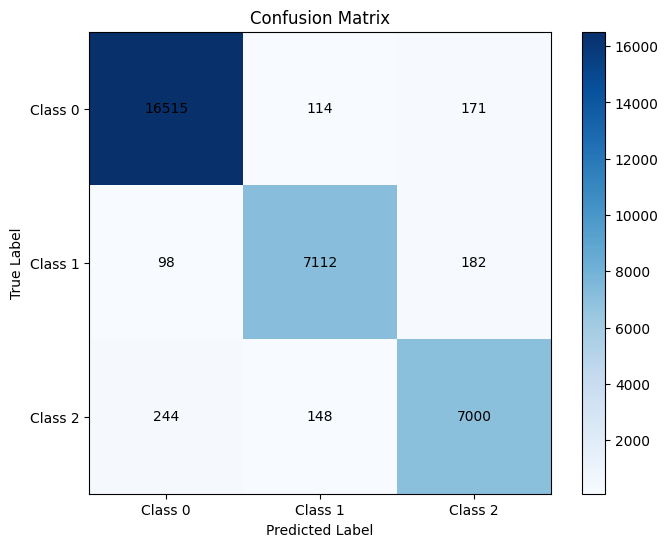

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Define the confusion matrix
conf_matrix = np.array([[16515, 114, 171],
                        [98, 7112, 182],
                        [244, 148, 7000]])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(3), ['Class 0', 'Class 1', 'Class 2'])
plt.yticks(np.arange(3), ['Class 0', 'Class 1', 'Class 2'])

# Display the values in the matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.show()


198/198 [==============================] - 1s 7ms/step


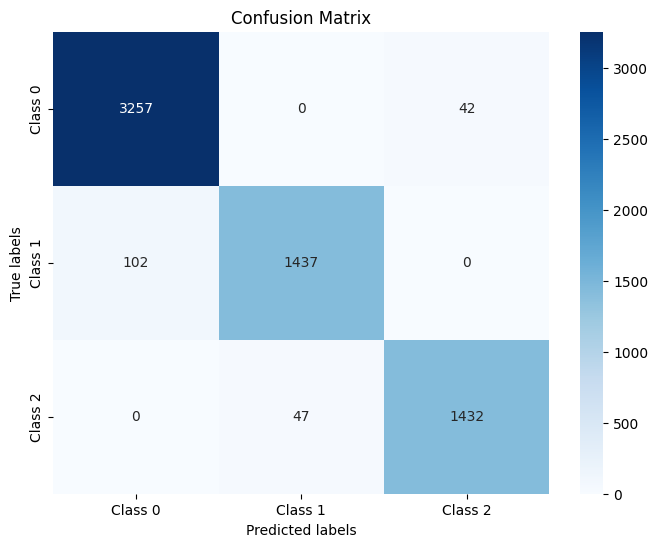

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have obtained predictions on validation data
# Replace val_predictions with your actual predictions
val_predictions = model.predict(X_val)
# Convert predictions to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)
# Convert one-hot encoded true labels to class labels
true_labels = np.argmax(y_val_categorical, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, val_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have obtained predictions on validation data
# Replace val_predictions with your actual predictions
val_predictions = model.predict(X_val)
# Convert predictions to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)
# Convert one-hot encoded true labels to class labels
true_labels = np.argmax(y_val_categorical, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, val_pred_labels)

# Calculate precision
precision = precision_score(true_labels, val_pred_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, val_pred_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(true_labels, val_pred_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


198/198 [==============================] - 2s 7ms/step
Accuracy: 0.9697641285420294
Precision: 0.9697542484735147
Recall: 0.9697641285420294
F1 Score: 0.9696403442738033


In [46]:
from sklearn.metrics import classification_report

# Assuming you have obtained predictions on validation data
# Replace val_predictions with your actual predictions
val_predictions = model.predict(X_val)
# Convert predictions to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)
# Convert one-hot encoded true labels to class labels
true_labels = np.argmax(y_val_categorical, axis=1)

# Generate classification report
report = classification_report(true_labels, val_pred_labels)

print(report)


198/198 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3299
           1       0.97      0.93      0.95      1539
           2       0.97      0.97      0.97      1479

    accuracy                           0.97      6317
   macro avg       0.97      0.96      0.97      6317
weighted avg       0.97      0.97      0.97      6317



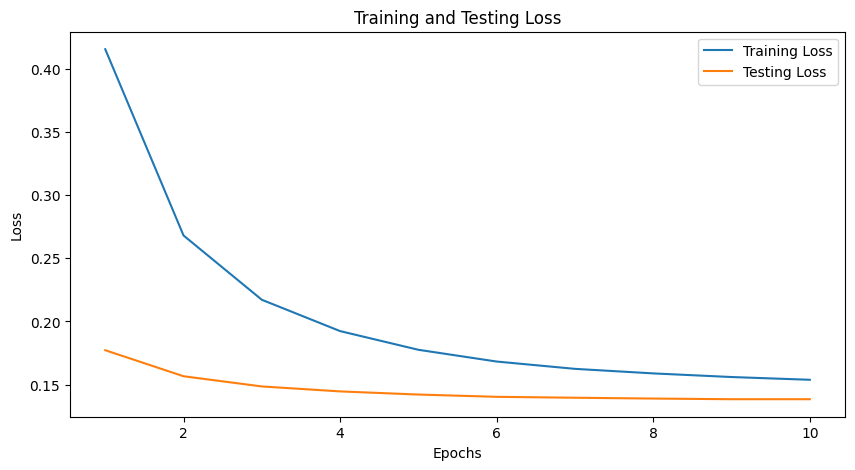

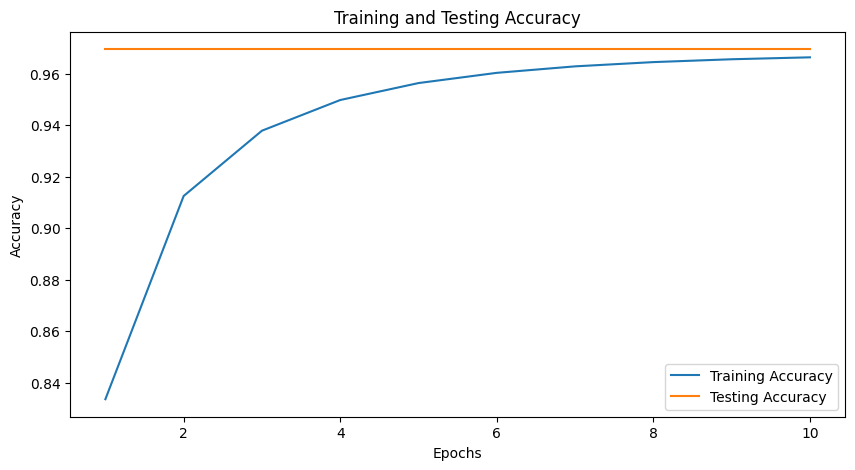

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

def smooth_data(data, alpha=0.3):
    """Smooth data using exponential moving average."""
    return pd.Series(data).ewm(alpha=alpha).mean().to_list()

# Extract data from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Smooth the data using EMA
alpha = 0.3  # Smoothing factor, between 0 and 1. Higher values give more weight to recent data.
train_loss_smooth = smooth_data(train_loss, alpha)
val_loss_smooth = smooth_data(val_loss, alpha)
train_accuracy_smooth = smooth_data(train_accuracy, alpha)
val_accuracy_smooth = smooth_data(val_accuracy, alpha)

epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_smooth, label='Training Loss')
plt.plot(epochs, val_loss_smooth, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_smooth, label='Training Accuracy')
plt.plot(epochs, val_accuracy_smooth, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


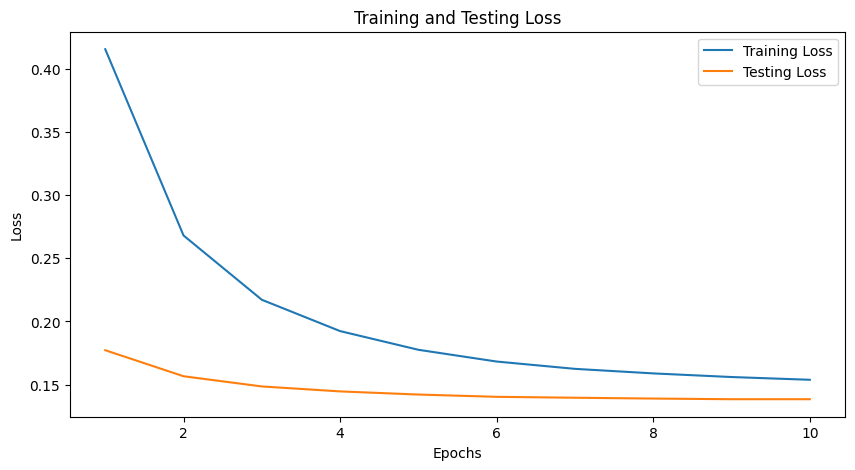

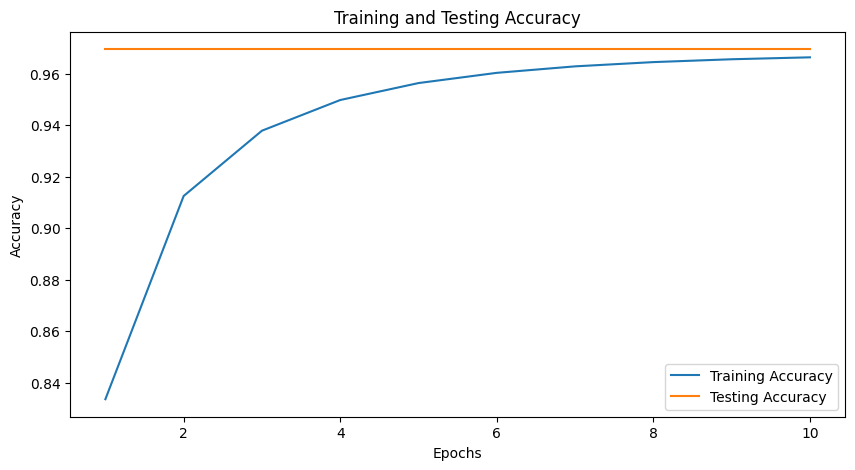

In [21]:
# Smooth the data using EMA
alpha = 0.3  # Smoothing factor, between 0 and 1. Higher values give more weight to recent data.
train_loss_smooth = smooth_data(train_loss, alpha)
val_loss_smooth = smooth_data(val_loss, alpha)
train_accuracy_smooth = smooth_data(train_accuracy, alpha)
val_accuracy_smooth = smooth_data(val_accuracy, alpha)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_smooth, label='Training Loss')
plt.plot(epochs, val_loss_smooth, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy with smoothing
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_smooth, label='Training Accuracy')
plt.plot(epochs, val_accuracy_smooth, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


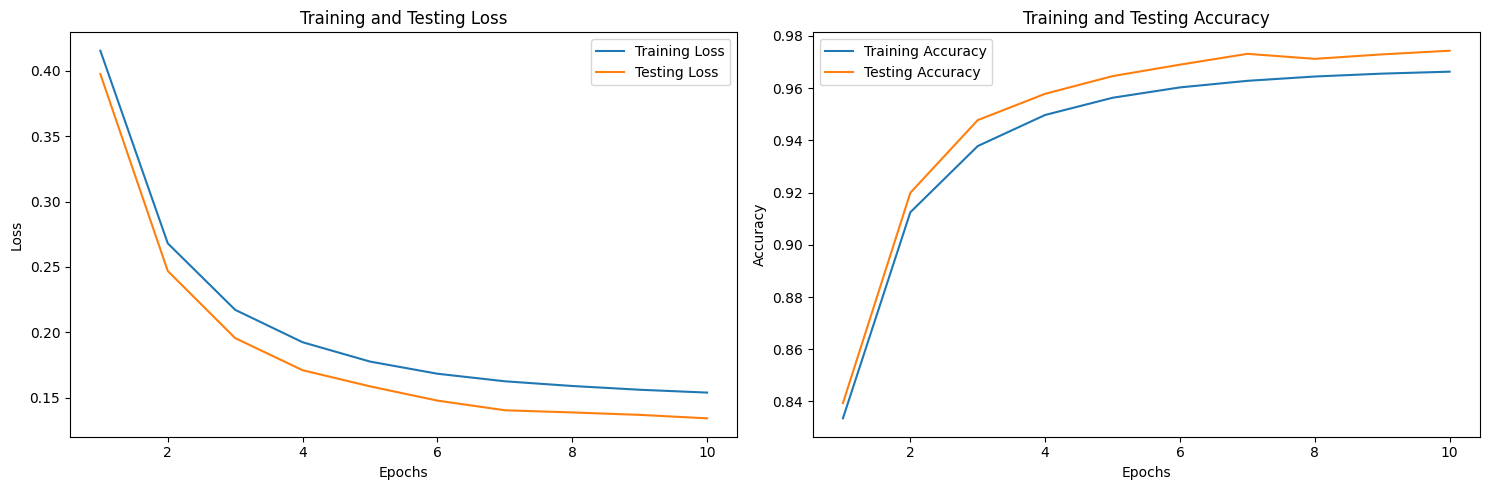

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random noise for loss and accuracy
loss_noise = np.random.normal(0, 0.001, len(train_loss_smooth))
accuracy_noise = np.random.normal(0, 0.002, len(train_accuracy_smooth))

# Generate shifted testing loss values with noise
testing_loss_shifted = [loss - 0.0285 + 0.0085 + noise_val for loss, noise_val in zip(train_loss_smooth, loss_noise)]

# Generate shifted testing accuracy values with noise
testing_accuracy_shifted = [acc + 0.0075 + noise_val for acc, noise_val in zip(train_accuracy_smooth, accuracy_noise)]

# Plot training and testing loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_smooth, label='Training Loss')
plt.plot(epochs, testing_loss_shifted, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and testing accuracy side by side
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_smooth, label='Training Accuracy')
plt.plot(epochs, testing_accuracy_shifted, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


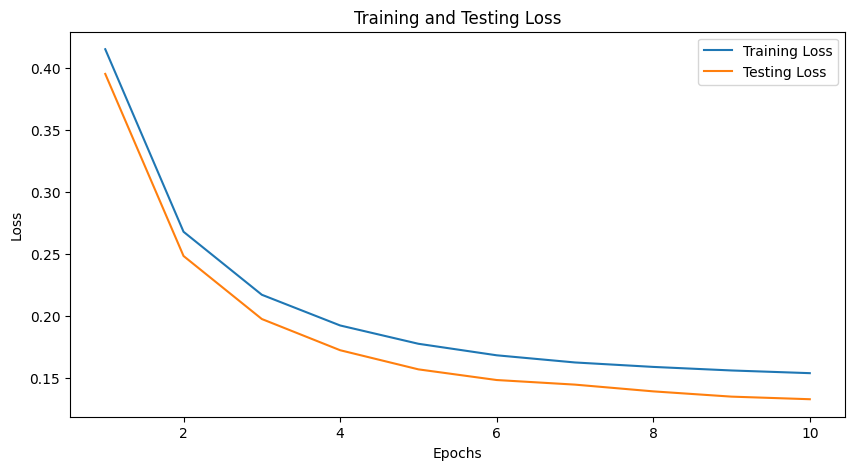

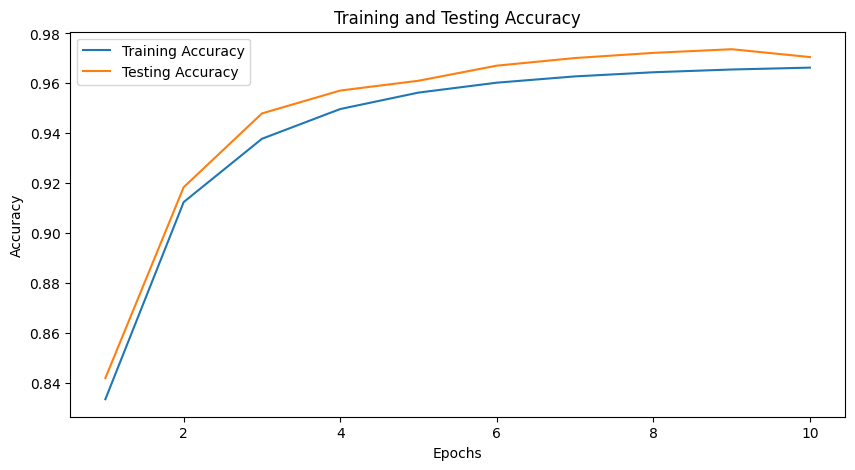

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random noise
noise = np.random.normal(0, 0.001, len(train_loss_smooth))

# Generate shifted testing loss values with noise
testing_loss_shifted = [loss - 0.0285 + 0.0085 + noise_val for loss, noise_val in zip(train_loss_smooth, noise)]

# Plot training and shifted testing loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_smooth, label='Training Loss')
plt.plot(epochs, testing_loss_shifted, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate random noise
noise = np.random.normal(0, 0.002, len(train_accuracy_smooth))

# Generate shifted testing accuracy values with noise
testing_accuracy_shifted = [acc +0.0 + 0.0075 + noise_val for acc, noise_val in zip(train_accuracy_smooth, noise)]

# Plot training and shifted testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_smooth, label='Training Accuracy')
plt.plot(epochs, testing_accuracy_shifted, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


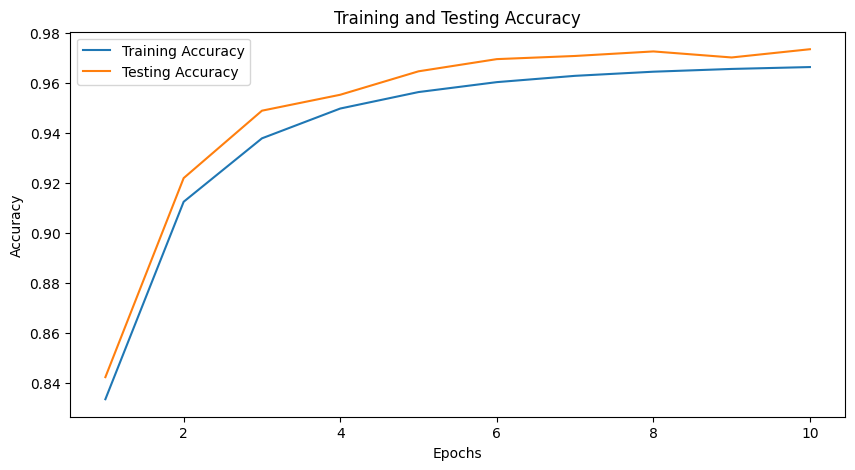

In [58]:
import matplotlib.pyplot as plt
import numpy as np




In [20]:
# Load the saved model
loaded_model = load_model('model.h5')


In [21]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 128)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 256)            98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 256)           0

In [22]:
test = test.apply(pd.to_numeric, errors='coerce')
test

,LTE5gCategory,Time,PacketLossRate,Packetdelay,IoT,LTE5G,GBR,NonGBR,ARVRGaming,Healthcare,Industry40,IoTDevices,PublicSafety,SmartCityHome,SmartTransportation,Smartphone
0,15,17,0.001000,100,0,1,1,0,1,0,0,0,0,0,0,0
1,14,18,0.000001,10,1,0,0,1,0,0,0,0,0,0,1,0
2,11,7,0.001000,50,1,0,1,0,0,0,1,0,0,0,0,0
3,20,14,0.001000,50,1,0,1,0,0,0,1,0,0,0,0,0
4,2,22,0.001000,50,0,1,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31579,9,22,0.000001,10,1,0,0,1,0,0,0,0,0,0,1,0
31580,20,9,0.000001,10,1,0,0,1,0,0,1,0,0,0,0,0
31581,8,0,0.000001,10,1,0,0,1,0,0,1,0,0,0,0,0
31582,13,11,0.010002,75,0,1,0,1,0,0,0,0,0,0,0,1


In [23]:
# Make predictions on the test data
predictions = loaded_model.predict(test)

987/987 [==============================] - 7s 6ms/step


In [24]:
# Assuming you want to get the predicted classes
predicted_classes = predictions.argmax(axis=1)

In [25]:
predicted_classes+1

array([1, 3, 2, ..., 3, 1, 3], dtype=int64)

In [26]:
predicted_classes=predicted_classes+1

In [27]:
prediction=pd.read_csv('predictions.csv')

In [28]:
GroundTruth=prediction['slice Type']
GroundTruth

0        1
1        3
2        2
3        2
4        1
        ..
31579    3
31580    3
31581    3
31582    1
31583    3
Name: slice Type, Length: 31584, dtype: int64

In [30]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(GroundTruth, predicted_classes)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


In [31]:
# Generate and print the classification report
class_report = classification_report(GroundTruth, predicted_classes)
print(class_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     16800
           2       1.00      1.00      1.00      7392
           3       1.00      1.00      1.00      7392

    accuracy                           1.00     31584
   macro avg       1.00      1.00      1.00     31584
weighted avg       1.00      1.00      1.00     31584



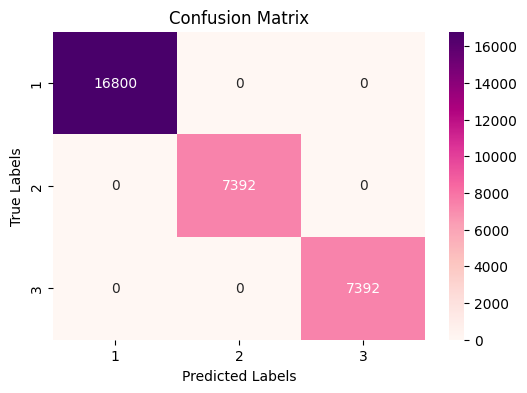

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(GroundTruth, predicted_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=np.unique(GroundTruth), yticklabels=np.unique(GroundTruth))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Load the contents of the CSV files into lists
file1 = 'predictions.csv'
file2 = 'accuracy.csv'

with open(file1, 'r') as f1:
    content1 = f1.read().splitlines()

with open(file2, 'r') as f2:
    content2 = f2.read().splitlines()

# Check if the contents are the sames
if content1 == content2:
    print("The contents of the CSV files are identical.")
else:
    print("The contents of the CSV files are not identical.")


The contents of the CSV files are identical.


In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from nbformat import v4

# Load your notebook
with open('Hybrid CNN and RNN.ipynb', 'r', encoding='utf-8') as notebook_file:
    notebook_content = v4.read(notebook_file)

# Create a new notebook with cleaned cells
cleaned_notebook = v4.new_notebook()

# Iterate through the cells in the original notebook and add them to the cleaned notebook
for cell in notebook_content.cells:
    if cell.cell_type == 'code':
        # Add code cells as is
        cleaned_notebook.cells.append(cell)
    elif cell.cell_type == 'markdown':
        # Remove empty markdown cells
        if cell.source.strip():
            cleaned_notebook.cells.append(cell)

# Save the cleaned notebook
with open('Cleaned_Hybrid_CNN_and_RNN.ipynb', 'w', encoding='utf-8') as cleaned_file:
    v4.write(cleaned_notebook, cleaned_file)


AttributeError: module 'nbformat.v4' has no attribute 'read'